In [ ]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
from tensorflow.keras import layers

E0000 00:00:1753080634.840512      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [ ]:
# Configs
INPUT_DIR = Path("./output_wav2vec_precomputed_features")
OUTPUT_DIR = Path("./output_conformer_training_tpu")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection', 'NoStutter']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 16 # Batch size for each TPU core
EPOCHS = 50
LEARNING_RATE = 1e-4
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
OUTPUT_DIR = Path("./output_cnn_training_tpu")
BEST_MODEL_PATH = OUTPUT_DIR / "best_cnn_model_tpu.keras"

In [ ]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    print('Found TPU: ', tpu.master())
    
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print("TPU successfully initialized.")
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

In [ ]:
print("\n--- Loading all compressed features into RAM... ---")

train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']

print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")


--- Loading all compressed features into RAM... ---
All compressed data loaded successfully.
X_train shape: (30778, 150, 768)


In [ ]:
print("\n--- Building tf.data pipeline from in-memory arrays... ---")

def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")


--- Building tf.data pipeline from in-memory arrays... ---
Datasets created successfully.


In [ ]:
import gc
gc.collect()

In [ ]:
with strategy.scope():
    def build_cnn_classifier(input_shape, num_classes):
        inputs = tf.keras.layers.Input(shape=input_shape)
    
        # 1. Convolutional Blocks
        # These layers learn local patterns from the sequence
        x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    
        x = tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
    
        # 2. Pooling Layer
        # We still use pooling, but now it's summarizing the FEATURES the CNN has learned
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
        # 3. Classifier Head
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
    
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy', 
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc', multi_label=True)
            ]
        )
        return model

    model = build_cnn_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)


I0000 00:00:1753080880.995776      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 150, 128)       │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 75, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,806 (1.64 MB)

 Trainable params: 428,038 (1.63 MB)

 Non-trainable params: 768 (3.00 KB)

In [9]:
print("\n--- Starting Training on TPU... ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


--- Starting Training on TPU... ---
Epoch 1/50


I0000 00:00:1753080947.272177      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:9486436978024571929
I0000 00:00:1753080947.933552     899 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(1635158760567141055), session_name()
I0000 00:00:1753080950.471476     899 tpu_compile_op_common.cc:245] Compilation of 1635158760567141055 with session name  took 2.537646053s and succeeded
I0000 00:00:1753080950.483511     899 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(1635158760567141055), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_9486436978024571929", property.function_library_fingerprint = 5468368413322420840, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z =

240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2545 - auc: 0.6168 - loss: 0.6191 - precision: 0.3851 - recall: 0.3959

I0000 00:00:1753080958.364114     949 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5689769231998353305), session_name()
I0000 00:00:1753080960.605334     949 tpu_compile_op_common.cc:245] Compilation of 5689769231998353305 with session name  took 2.241152955s and succeeded
I0000 00:00:1753080960.615966     949 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5689769231998353305), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_9486436978024571929", property.function_library_fingerprint = 5468368413322420840, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "8,150,768,;8,6,;", property.guaranteed_constants_size = 0, embedding_parti

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2546 - auc: 0.6170 - loss: 0.6190 - precision: 0.3854 - recall: 0.3957

I0000 00:00:1753080977.527816      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:4635027755029087555
I0000 00:00:1753080977.892977     877 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(9266754272615861573), session_name()
I0000 00:00:1753080978.668309     877 tpu_compile_op_common.cc:245] Compilation of 9266754272615861573 with session name  took 775.275398ms and succeeded
I0000 00:00:1753080978.670902     877 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(9266754272615861573), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_4635027755029087555", property.function_library_fingerprint = 8865855551829958223, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z =


Epoch 1: val_auc improved from -inf to 0.68014, saving model to output_cnn_training_tpu/best_cnn_model_tpu.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.2546 - auc: 0.6171 - loss: 0.6189 - precision: 0.3856 - recall: 0.3955 - val_accuracy: 0.2207 - val_auc: 0.6801 - val_loss: 0.5791 - val_precision: 0.5429 - val_recall: 0.1416
Epoch 2/50
239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3000 - auc: 0.6900 - loss: 0.5503 - precision: 0.5190 - recall: 0.3164
Epoch 2: val_auc improved from 0.68014 to 0.70868, saving model to output_cnn_training_tpu/best_cnn_model_tpu.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 37s 100ms/step - accuracy: 0.3002 - auc: 0.6902 - loss: 0.5502 - precision: 0.5193 - recall: 0.3165 - val_accuracy: 0.2180 - val_auc: 0.7087 - val_loss: 0.5765 - val_precision: 0.5240 - val_recall: 0.3905
Epoch 3/50
239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3200 - auc: 0.7106 - loss: 0.5381 - precision: 0.5614 - recall: 0.3218
Epoch 3: val_auc improved 


--- Evaluating Model on the Test Set ---


I0000 00:00:1753082014.724049      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2301850986018435616
E0000 00:00:1753082014.734152      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/batch_normalization_1/Cast/ReadVariableOp.
I0000 00:00:1753082014.773638     961 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(954771757600592024), session_name()
I0000 00:00:1753082015.038225     961 tpu_compile_op_common.cc:245] Compilation of 954771757600592024 with session name  took 264.486545ms and succeeded
I0000 00:00:1753082015.039116     961 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(954771757600592024), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_2301850986018435616", property.function_library_fingerprint = 1272113088655863968, property.mlir_module_finge

67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

I0000 00:00:1753082020.819293      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14770128945212406342
I0000 00:00:1753082021.000808     956 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16332615767959319593), session_name()
I0000 00:00:1753082021.526801     956 tpu_compile_op_common.cc:245] Compilation of 16332615767959319593 with session name  took 525.938739ms and succeeded
I0000 00:00:1753082021.527625     956 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16332615767959319593), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14770128945212406342", property.function_library_fingerprint = 3234153689653922939, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, to

68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step

--- Classification Report (Multi-Label) ---
              precision    recall  f1-score   support

Prolongation       0.85      0.18      0.29      2613
       Block       0.54      0.54      0.54      3501
    SoundRep       0.61      0.36      0.46      1891
     WordRep       0.55      0.38      0.45      1742
Interjection       0.63      0.81      0.71      3344
   NoStutter       0.64      0.17      0.27      1674

   micro avg       0.60      0.45      0.52     14765
   macro avg       0.64      0.41      0.45     14765
weighted avg       0.64      0.45      0.48     14765
 samples avg       0.48      0.42      0.42     14765


--- Generating plots for model training history... ---


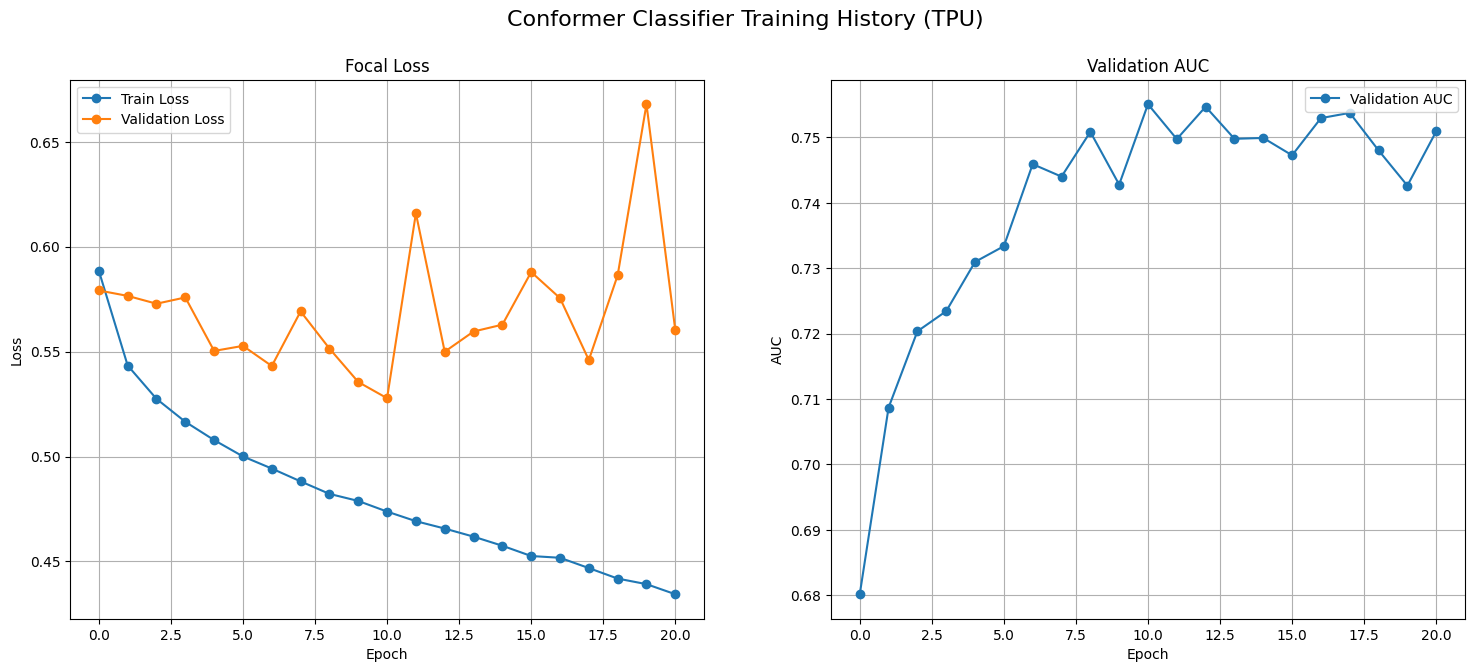


--- Pipeline complete. All outputs saved in 'output_cnn_training_tpu' directory. ---


In [ ]:
print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n--- Classification Report (Multi-Label) ---")
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Conformer Classifier Training History (TPU)', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Focal Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history_conformer_tpu.png")
plt.show()

print(f"\n--- Pipeline complete. All outputs saved in '{OUTPUT_DIR}' directory. ---")